# 12-Finding Protein Folding by Quantum Annealing

2012年に、Alejandroらがタンパク質折り畳み問題を量子アニーリングマシン(D-wave)を用いて解きました[1]。

ここでタンパク質折り畳み問題とは、「アミノ酸配列という１次元的情報からそのタンパク質の３次元的立体構造を予測すること」です。
そもそも、アミノ酸配列によってタンパク質は特徴付けられ、１つのアミノ酸配列に対して１つの固有の立体構造が対応することが知られております。
タンパク質はその固有の立体構造を持って初めて生体高分子としての機能を果たすため、アミノ酸配列の情報からそのタンパク質の立体構造を予測することは非常に重要な問題です。しかし、アミノ酸配列とタンパク質の立体構造との因果関係はまだよくわかっていないため、非常に難しい問題です。

このチュートリアルでは、SAを用いてタンパク質折り畳み問題を解きます。

## 問題の概要とHydrophobic-Polar(HP)モデル、Mijazawa-Jernigan(MJ)モデル 

### 問題概要

タンパク質の立体構造をラティスフォールディングモデル[2]という単純な格子モデルとして捉え、HUBOの形式にエンコードし、最適解を求め、立体構造を決定します。特に参考論文[1]では、２次元上の構造問題として見做し、解いています。ラティスフォールディングモデルにはいくつか種類があり、 以下代表的な２つのモデル、HPモデルとMJモデルについて紹介します。


### HPモデル 
タンパク質は数十から数百程度のアミノ酸配列からなるポリペプチドが折り畳まった安定した立体構造を持つが、その立体構造を決定するために、ポリペプチドの３次元立体構造をそのままの状態で扱うのは、計算量が膨大でスーパーコンピュータ等を利用しても難しいのが現状です。
なぜなら、タンパク質分子のエネルギーを計算するには、水素結合、静電相互作用、ファンデルワールス力、疎水相互作用等の様々な力を考慮する必要があるからです。しかし、疎水相互作用だけを扱った極めて単純なモデルでもある程度のことが説明できます。

LauとDillは疎水性相互作用のみを考慮した格子モデルHPモデル[2]を提案しました。
このモデルは、アミノ酸は疎水性と親水性の2種類のみからなると見做し､タンパク質のアミノ酸配列をHとPの配列として表現されるものです。そして､Hモノマー同士が最近接格子にきた場合､自由エネルギーが得をするというモデルです。

参考：
- https://repository.kulib.kyoto-u.ac.jp/dspace/bitstream/2433/96792/1/KJ00004709268.pdf
- http://www.iba.t.u-tokyo.ac.jp/iba/AI/HP.pdf


### MJモデル

HPモデルは、アミノ酸は疎水性と親水性の2種類のみからなると見做しているため、20種類のアミノ酸どうしの相互作用の大きさの違いは考慮していません。しかし、実際のタンパク質では、アミノ酸どうしの相互作用の大きさの違いがあります。この違いを考慮したモデルが、MJモデルです。

MJモデルは、立体構造が既知のタンパク質を多数集め、それらの中から互いに近距離にあるアミノ酸ペアの個数を数え上げ、図４左下のアミノ酸間の相互作用エネルギーとして表現したものです。
立体構造群の中でのアミノ酸ペアの数が多ければ、そのアミノ酸ペアのエネルギーの値も大きくなります。つまり、MJエネルギーはアミノ酸ペアを形成しやすい・しにくい傾向を表現している指標と言えます。


参考論文[1]では、タンパク質のような性質を記述するには、20種類のアミノ酸すべての間のユニークな相互作用を明示的に考慮した一般化モデルの方がより正確に記述できると考え、今回は参考論文[3]のTable3に報告されているMJモデルを用いています。



## 解法の概要

今回使用するアミノ酸配列は、2次元のMJモデル、Proline-Serine-Valine-Lysine-Methionine-Alanineの6アミノ酸配列(1文字のアミノ酸配列表記ではPSVKMA)です。

後述のように特定のアミノ酸配列が隣接すると安定状態になり、エネルギーが減ります。このエネルギーの安定化を使ってコスト関数を最小化させることを考えます。また、今回アミノ酸配列を全て一度に処理するのは難しいのでいくつかのパターンに分けます。

すでにいくつかの折り畳まれたパターンから出発して安定状態を求めます。具体的には、実験３のschemeに絞ります。
コスト関数の定式化を定式化する際に場合分けのパターンが多くないため、比較的容易に書き出すことができるためです。

本チュートリアルでは以下の順で詳細な解法手順を説明します。

1. ラティスフォールディングのビット表現方法
2. コスト関数の定式化
3. HUBOの直接解法
4. HUBOによる直接解法と参考論文[1]の結果との比較

## 1. ラティスフォールディングのビット表現方法

タンパク質をラティスフォールディングモデルとして、２値表現で埋込みます。1つの結合につき2つのビットが必要であり、結合の方向は、00(下向き)、01(右向き)、10(左向き)、11(上向き)と表記します。この例では、任意の6つのアミノ酸配列の可能な折り方の1つを示しています。
任意の$N$-アミノ酸配列の折り畳みは、$010q_\mathrm{1}q_\mathrm{2}q_\mathrm{3}…q_{l-1}q_{l}(l=2N-5)$という変数の列で表すことができます。

<div>
    <img src="images/lattice_folding_mapping.png" width="400" height="300"><br />
    図2：ラティスフォールディングの埋込みの様子（[1]のFigure2(a)）
</div>

## 　2. コスト関数の定式化

タンパク質の構造をラティスフォールディングモデルとして考えるにあたり、コスト関数を定式化すると、以下のようになります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw} + E_\mathrm{ext}$$

- 第１項: タンパク質のアミノ酸配列が重ならない場合のエネルギー
- 第２項: はアミノ酸配列同士の近接の相互作用のエネルギー(pw: pair-wise)
- 第３項: 外部からの影響のエネルギー(ext: external)

論文中の実験３については、第３項は使用しないため、コスト関数は以下となります。

$$E_\mathrm{p} = E_\mathrm{onsite} + E_\mathrm{pw}$$


本チュートリアルでは、図3のScheme3のExperiment3を初期状態にして考えます。アミノ酸配列は、

P-S-V-K-M-A

この順番ですが、今回はある程度折りたたまれた状態で始まります。

<div>
    <img src="images/scheme.png" width="600" height="600"><br />
     図3：Experiment3を初期状態([1]のFigure3(b)を改変)
</div>


### 2次元構造のビット表現方法

この場合、PSVKまでは決まっていて、Mは下か左が決まっているので、Pから順番に書いてみると以下のように3ビットの式に還元されます。

$$010010q_10q_2q_3$$

初めの6ビットについては、アミノ酸P, S, V, Kが、右、下、左の構造を取るため、010010と表される。

続いて、Mは下か左しかないので、$00$か$10$なので、$0$は決まっていて、残りの$q_1$から$q_3$をHUBO問題として求めます。

### コスト関数設計

コスト関数設計の様子を以下の図４に示しました。図４の詳細について説明します。

<div>
    <img src="images/make_costfunction_about_protein_folding.png" width="600" height="400"><br />
    図4：コスト関数の定式化([1]のFigure3(a)を一部利用)
</div>

1. 実験3の初期状態では、P-Kの相互作用で-1分のエネルギーが生じます。

以下、2~5は折り畳まれ得る状態に応じて、場合分けして、エネルギー最小になるようにコスト関数を設計します。
最近接のアミノ酸間の相互作用によるコストは図４の表を用い、アミノ酸間の折り返しによるコストは+11と定義する。

2. $(q_{1},q_{2},q_{3})=(0,0,1)$の場合の状態です。V-Aの相互作用で-4分のエネルギーが生じます。
この場合のコスト関数は以下のように定式化すれば良いです。

 $$(1-q_{1})(1-q_{2})q_{3}(-4)$$

3. $(q_{1},q_{2},q_{3})=(0,1,1)$の場合の状態です。P-A,V-Aの相互作用で-2,-4分のエネルギーが生じます。
またM-Aの押り返しによるコスト+11が生じます。トータルで+5の重みがかかります。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$(1-q_{1})q_{2}q_{3}(+5)$$

4. $(q_{1},q_{2},q_{3})=(1,1,1)$の場合の状態です。P-Aの相互作用で-2分のエネルギーが生じます。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$q_{1}q_{2}q_{3}(-2)$$

5. $(q_{1},q_{2},q_{3})=(1,0,1)$の場合の状態です。P-A,V-Aの相互作用で-2,-4分のエネルギーが生じます。
またM-Aの押り返しによるコスト+11が生じます。トータルで+5の重みがかかります。
この場合のコスト関数は以下のように定式化すれば良いです。

　$$(1-q_{1})q_{2}q_{3}(+5)$$


1~5より、コスト関数は最終的に以下のようになります。

$$E = -1-4q_3+9q_1q_3+9q_2q_3-16q_1q_2q_3$$

## 3. HUBOの直接解法
　2でコスト関数を定式化したので、実際にopenjijを使って解きます。

In [11]:
# HUBOを定義します。
polynomial = {():-1, (3,): -4, (1,3): 9, (2,3): 9, (1,2,3): -16}

In [12]:
import openjij as oj

# HUBOメソッドを利用するためには、SASamplerメソッドを用いる必要があります。
sampler = oj.SASampler()

# SAによるシミュレーションを行う回数を指定します。ここでは、参考論文[1]でD-waveを用いて１万回の測定を行ったため、１万回に指定します。
num_sa = 10000 

# 変数は、バイナリ変数、変数の更新方式は、single spin flipを指定します。
response = sampler.sample_hubo(polynomial, vartype="BINARY", updater="single spin flip", num_reads=num_sa)

energy_hubo = response.energies
print(energy_hubo)

[-3. -1. -5. ... -5. -5. -5.]


 sample_huboメソッドを用いて100回実行したところ、異なる種類の解が複数回得られることがわかります。
 解の頻度について、エネルギーのヒストグラムとして可視化してみましょう。

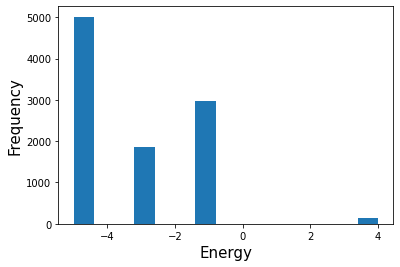

In [13]:
import matplotlib.pyplot as plt

plt.hist(energy_hubo, bins=15)
plt.xlabel('Energy', fontsize=15)
plt.ylabel('Frequency', fontsize=15)
plt.show()

エネルギーが-5, -3, -1, 4が得られていることがわかります。内訳として、−５, −１の解が相対的に多く得られていることがわかります。

ここで得られた解が元の問題に対する最適解かどうかを調べるために、dimodのExactPolySolverを使って確認します。

In [14]:
import dimod

# 元のHUBOの最適解を確認します。
sampleset = dimod.ExactPolySolver().sample_hubo(H=polynomial)
print('最適解:', sampleset.first.sample)
print('対応するエネルギー:',sampleset.first.energy)

最適解: {1: 0, 2: 0, 3: 1}
対応するエネルギー: -5.0


元のHUBOに対する最適解は、$(q_{1},q_{2},q_{3})=(0,0,1)$であり、対応するエネルギーは-5.0であることがわかります。
また最適解のラティスフォールディングモデルは以下のようになります。


<div>
    <img src="images/optimal_folding_structure.png" width="300" height="300"><br />
    図5： 最適なラティスフォールディング構造（[1]のFigure3(c)の一部）
</div>

## 4. HUBOによる直接解法と参考論文[1]の結果との比較

最後に、HUBOによる直接解法と参考論文[1]の結果との比較します。

以下の図６は、参考論文[1]のD-waveの測定結果であり、各エネルギーにおいてタンパク質がとり得るラティスフォールディング構造を示したものです。

なお、参考論文[1]では、HUBOをQUBO変換してから、D-waveを用いて解いています。

<div>
    <img src="images/protein_folding_qa_result.png" width="400" height="500"><br />
    図6： D-waveの測定結果で得られたラティスフォールディング構造とエネルギーのパターン（[1]のFigure3(c)）
</div>

実験３の測定結果は、図の青色の構造であり、今回は青色の構造のみを観察すれば良いです。

図6に従い、参考論文[1]のエネルギー測定結果のリストを以下で作成します。

In [15]:
import numpy as np

energy_qa = np.zeros(num_sa)
# エネルギー -5の解は、4164回得られました。
energy_qa[:4164] = -5 
# エネルギー -3の解は、1317回得られました。
energy_qa[4164:4164+1317] = -3
# エネルギー -1の解は、４状態の構造について、それぞれ415回, 381回, 1371回, 1552回の計3719回得られました。
energy_qa[4164+1317:4164+1317+415+381+1371+1552] = -1

# 残りの800回は、エネルギー 0以上の解が得られました。

print(energy_qa)

[-5. -5. -5. ...  0.  0.  0.]


両者を比較した結果をヒストグラムにすると以下のようになります。

Text(0, 0.5, 'Frequency')

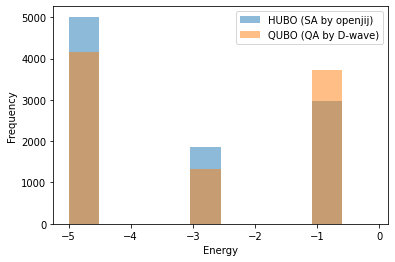

In [17]:
plt.hist(energy_hubo, label='HUBO (SA by openjij)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.hist(energy_qa, label='QUBO (QA by D-wave)', range=(-5, -0.1), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

SAとQAなので単純比較はできませんが、今回の結果からは、HUBO直接解法(openjijを用いたSA)の方が、QUBO変換解法(D-waveを用いたQA)に比べ、
最適解を導くエネルギーを多く得ることができていることがわかります。

## 引用文献

1. Alejandro Perdomo-Ortiz, et.al "Finding low-energy conformations of lattice protein models by quantum annealing". Scientific Reports volume 2, Article number: 571 (2012)
2. Dill KA (March 1985). "Theory for the folding and stability of globular proteins". Biochemistry. 24 (6)
3. Miyazawa, S. & Jernigan, R. L. Residue-residue potentials with a favorable contact pair term and an unfavorable high packing density term, for simulation and threading. J. Mol. Biol. 256, 623–644 (1996).

## Ex.1

$$
\begin{aligned}
E_{\text {PSVKMA }}^{e x p 1} &\left(\boldsymbol{q}_{e x p 1}\right)=-3 q_{2}+7 q_{1} q_{2}+18 q_{2} q_{3}-15 q_{1} q_{2} q_{3}-4 q_{1} q_{4}-2 q_{2} q_{4}+15 q_{1} q_{2} q_{4} \\
&+7 q_{3} q_{4}+4 q_{1} q_{3} q_{4}-7 q_{2} q_{3} q_{4}-24 q_{1} q_{2} q_{3} q_{4}+7 q_{2} q_{5}+4 q_{1} q_{2} q_{5}-18 q_{2} q_{3} q_{5} \\
&+7 q_{4} q_{5}+4 q_{1} q_{4} q_{5}-7 q_{2} q_{4} q_{5}-24 q_{1} q_{2} q_{4} q_{5}-18 q_{3} q_{4} q_{5}+20 q_{2} q_{3} q_{4} q_{5} \\
&+29 q_{1} q_{2} q_{3} q_{4} q_{5}
\end{aligned}

$$

[-4. -4. -4. ... -4. -4.  0.]
[-5. -5. -5. ...  1.  1.  1.]


Text(0, 0.5, 'Frequency')

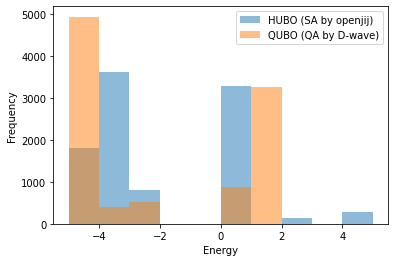

In [64]:
# HUBOを定義します。
polynomial = {
    (2,): -3, (1,2): 7, (2,3): 18, (1,2,3): -15, (1,4): -4, (2,4): -2, (1,2,4): 15,
    (3,4): 7, (1,3,4): 4, (2,3,4): -7, (1,2,3,4): -24, (2,5): 7, (1,2,5): 4, (2,3,5): -18,
    (4,5): 7, (1,4,5): 4, (2,4,5): -7, (1,2,4,5): -24, (3,4,5): -18, (2,3,4,5): 20,
    (1,2,3,4,5): 29
    }


import openjij as oj

# HUBOメソッドを利用するためには、SASamplerメソッドを用いる必要があります。
sampler = oj.SASampler()

# SAによるシミュレーションを行う回数を指定します。ここでは、参考論文[1]でD-waveを用いて１万回の測定を行ったため、１万回に指定します。
num_sa = 10000 

# 変数は、バイナリ変数、変数の更新方式は、single spin flipを指定します。
response = sampler.sample_hubo(polynomial, vartype="BINARY", updater="single spin flip", num_reads=num_sa)

energy_hubo = response.energies
print(energy_hubo)


import numpy as np

energy_qa = np.ones(num_sa)
# エネルギー -5の解は、4934回得られました。
energy_qa[:4934] = -5 
# エネルギー -4の解は、3状態の構造について、それぞれ323回, 51回, 25回の計399回得られました。
energy_qa[4934:4934+323+51+25] = -4
# エネルギー  -3の解は、513回得られました。
energy_qa[4934+323+51+25:4934+323+51+25+513] = -3
# エネルギー 0の解は、12状態の構造について、それぞれ44回, 7回, 35回, 3回, 10回, 1回, 35回, 223回, 392回, 16回, 107回, 12回の計885回得られました。
energy_qa[4934+323+51+25+513:4934+323+51+25+513+44+7+35+3+10+1+35+223+392+16+107+12] = 0
# 残りの3269回は、エネルギー 0より大きい解が得られました。

print(energy_qa)

# plot
import matplotlib.pyplot as plt
plt.hist(energy_hubo, label='HUBO (SA by openjij)', range=(-5, 5), bins=10, alpha=0.5)
plt.hist(energy_qa, label='QUBO (QA by D-wave)', range=(-5, 5), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

In [36]:
response.first

Sample(sample={1: 0, 2: 1, 3: 0, 4: 1, 5: 0}, energy=-5.0, num_occurrences=1)

## Ex.2

$$
\begin{aligned}
E_{\mathrm{PSVKMA}}^{e x p 2} &\left(\boldsymbol{q}_{e x p 2}\right)=4 q_{1} q_{2}+15 q_{2} q_{3}-15 q_{1} q_{2} q_{3}-4 q_{1} q_{4}+2 q_{1} q_{2} q_{4}+7 q_{3} q_{4}+4 q_{1} q_{3} q_{4} \\
&-20 q_{2} q_{3} q_{4}+9 q_{1} q_{2} q_{3} q_{4}+7 q_{2} q_{5}+4 q_{1} q_{2} q_{5}-18 q_{2} q_{3} q_{5}+7 q_{4} q_{5}+4 q_{1} q_{4} q_{5} \\
&-20 q_{2} q_{4} q_{5}+9 q_{1} q_{2} q_{4} q_{5}-18 q_{3} q_{4} q_{5}+53 q_{2} q_{3} q_{4} q_{5}-33 q_{1} q_{2} q_{3} q_{4} q_{5}
\end{aligned}

$$

[ 0. -6. -6. ...  0. -6. -6.]
[-6. -6. -6. ...  1.  1.  1.]


Text(0, 0.5, 'Frequency')

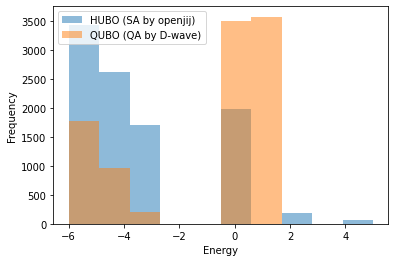

In [63]:
# HUBOを定義します。
polynomial = {
    (1,2): 4, (2,3): 15, (1,2,3): -15, (1,4): -4, (1,2,4): 2, (3,4): 7, (1,3,4): 4, 
    (2,3,4): -20, (1,2,3,4): 9, (2,5): 7, (1,2,5): 4, (2,3,5): -18, (4,5): 7, (1,4,5): 4,
    (2,4,5): -20, (1,2,4,5): 9, (3,4,5): -18, (2,3,4,5): 53, (1,2,3,4,5): -33
    }


import openjij as oj

# HUBOメソッドを利用するためには、SASamplerメソッドを用いる必要があります。
sampler = oj.SASampler()

# SAによるシミュレーションを行う回数を指定します。ここでは、参考論文[1]でD-waveを用いて１万回の測定を行ったため、１万回に指定します。
num_sa = 10000 

# 変数は、バイナリ変数、変数の更新方式は、single spin flipを指定します。
response = sampler.sample_hubo(polynomial, vartype="BINARY", updater="single spin flip", num_reads=num_sa)

energy_hubo = response.energies
print(energy_hubo)


import numpy as np

energy_qa = np.ones(num_sa)
# エネルギー -6の解は、1767回得られました。
energy_qa[:1767] = -6 
# エネルギー -4の解は、2状態の構造について、それぞれ680回, 282回の計962回得られました。
energy_qa[1767:1767+680+282] = -4
# エネルギー -3の解は、2状態の構造について、それぞれ81回, 127回の計208回得られました。
energy_qa[1767+680+282:1767+680+282+81+127] = -3
# エネルギー 0の解は、12状態の構造について、それぞれ81回, 12回, 12回, 13回, 1回, 8回, 11回, 349回, 676回, 210回, 760回, 1359回の計3492回得られました。
energy_qa[1767+680+282+81+127:1767+680+282+81+127+81+12+12+13+1+8+11+349+676+210+760+1359] = 0
# 残りの3571回は、エネルギー 0より大きい解が得られました。
print(energy_qa)

# plot
import matplotlib.pyplot as plt
plt.hist(energy_hubo, label='HUBO (SA by openjij)', range=(-6, 5), bins=10, alpha=0.5)
plt.hist(energy_qa, label='QUBO (QA by D-wave)', range=(-6, 5), bins=10, alpha=0.5)
plt.legend()
plt.xlabel('Energy')
plt.ylabel('Frequency')

In [54]:
response.first

Sample(sample={1: 0, 2: 1, 3: 0, 4: 1, 5: 1}, energy=-6.0, num_occurrences=1)